# 1. Setup and Optimization for M1 Mac

In [1]:
# Install required libraries
!pip install -q pandas numpy matplotlib seaborn scikit-learn umap-learn faiss-cpu nltk
!pip install -q torch torchvision torchaudio
!pip install -q transformers datasets accelerate
!pip install -q sentencepiece protobuf  # Required for GatorTron

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
import json
import time
from sklearn.manifold import TSNE
import torch
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import faiss
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
def optimize_for_m1_mac():
    """Apply optimizations for running on M1 MacBook Air."""
    import platform

    # Check if running on macOS
    if platform.system() != 'Darwin':
        print("Not running on macOS, skipping M1 optimizations")
        return False

    print("Applying optimizations for M1 Mac...")

    # Configure PyTorch to use MPS (Metal Performance Shaders)
    import torch
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        print("MPS (Metal Performance Shaders) is available!")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        global device
        device = torch.device('mps')
        print(f"Using device: {device}")
        using_mps = True
    else:
        print("MPS not available. Using CPU.")
        device = torch.device('cpu')
        using_mps = False

    # Set memory optimization flags for PyTorch
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

    # Set lower values for GatorTron which is much larger than regular BERT
    global BATCH_SIZE, MAX_LENGTH, ACCUMULATION_STEPS
    BATCH_SIZE = 1  # Very small batch size due to large model
    MAX_LENGTH = 128  # Shorter sequence length to save memory
    ACCUMULATION_STEPS = 8  # Accumulate gradients to simulate larger batch

    print(f"M1 optimizations applied. Using batch size: {BATCH_SIZE}, max length: {MAX_LENGTH}")
    print(f"Using gradient accumulation steps: {ACCUMULATION_STEPS}")
    return using_mps

# Run M1 optimization
using_mps = optimize_for_m1_mac()
if not using_mps:
    # Set device and parameters for non-M1 Mac
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    BATCH_SIZE = 2  # Still small due to GatorTron's size
    MAX_LENGTH = 256
    ACCUMULATION_STEPS = 4

print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Not running on macOS, skipping M1 optimizations
Using device: cuda
PyTorch version: 2.6.0+cu124


# 2. Data Loading and Exploration

In [4]:
# Load the ICD-11 data
icd11_df = pd.read_csv('icd11_data_raw.csv')

# Display basic information
print(f"Total number of ICD-11 codes: {len(icd11_df)}")
print(f"Columns in the dataset: {icd11_df.columns.tolist()}")

Total number of ICD-11 codes: 28087
Columns in the dataset: ['id', 'code', 'title', 'browser_url', 'class_kind', 'definition', 'parent', 'inclusions', 'foundation_children', 'foundation_child_references', 'index_terms', 'related_entities', 'full_text', 'children', 'postcoordination_scales', 'index_term_references', 'exclusions', 'exclusion_references', 'fully_specified_name']


In [5]:
# %%
# Check the first few rows
icd11_df.head()

,id,code,title,browser_url,class_kind,definition,parent,inclusions,foundation_children,foundation_child_references,index_terms,related_entities,full_text,children,postcoordination_scales,index_term_references,exclusions,exclusion_references,fully_specified_name
0,1937339080,1C22,Infections due to Chlamydia psittaci,https://icd.who.int/browse/2023-01/mms/en#1937...,category,Any condition caused by an infection with the ...,1127435854,Psittacosis; Ornithosis; Parrot fever,Pneumonia in chlamydia psittaci infection,Pneumonia in chlamydia psittaci infection: htt...,Infections due to Chlamydia psittaci; Psittaco...,1935107489,Infections due to Chlamydia psittaci Any condi...,NaN,NaN,NaN,NaN,NaN,NaN
1,1671640403,1F51.0,Gambiense trypanosomiasis,https://icd.who.int/browse/2023-01/mms/en#1671...,category,A disease caused by an infection with the prot...,875488052,West African sleeping sickness; Infection due ...,NaN,NaN,NaN,1945127438,Gambiense trypanosomiasis A disease caused by ...,1842725899; other; unspecified,"{'axis_name': 'hasManifestation', 'required': ...",NaN,NaN,NaN,NaN
2,1528414070,1A07,Typhoid fever,https://icd.who.int/browse/2023-01/mms/en#1528...,category,A condition caused by an infection with the gr...,135352227,NaN,NaN,NaN,NaN,911707612,Typhoid fever A condition caused by an infecti...,364534567; other; unspecified,"{'axis_name': 'hasManifestation', 'required': ...",NaN,NaN,NaN,NaN
3,328097188,1A36.12,Cutaneous amoebiasis,https://icd.who.int/browse/2023-01/mms/en#3280...,category,NaN,1777228366,NaN,NaN,NaN,Cutaneous amoebiasis; Amoebiasis of skin; Amoe...,911707612,Cutaneous amoebiasis Cutaneous amoebiasis; Amo...,NaN,NaN,NaN,NaN,NaN,NaN
4,1483190070,1D03,Infectious abscess of the central nervous system,https://icd.who.int/browse/2023-01/mms/en#1483...,category,A focal suppurative process of the brain paren...,1585949804,NaN,NaN,NaN,NaN,911707612,Infectious abscess of the central nervous syst...,443087096; 613341872; 1147230459; 1128677700; ...,"{'axis_name': 'specificAnatomy', 'required': '...",NaN,NaN,NaN,NaN


In [6]:
# %%
# Check for missing values
missing_values = icd11_df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
id                                 0
code                            1510
title                              1
browser_url                        0
class_kind                         0
definition                     20073
parent                             0
inclusions                     26528
foundation_children            26310
foundation_child_references    26310
index_terms                     3590
related_entities               25537
full_text                          0
children                       22664
postcoordination_scales        20958
index_term_references          24249
exclusions                     25595
exclusion_references           25619
fully_specified_name           27993
dtype: int64


In [7]:
# %%
# Analyze the text fields that we'll use for embeddings
text_columns = ['title', 'definition', 'inclusions', 'index_terms', 'full_text']

# Add a column with text length for each text field
for col in text_columns:
    icd11_df[f'{col}_length'] = icd11_df[col].fillna('').apply(len)

# Display statistics about text length
print("\nText length statistics:")
for col in text_columns:
    non_empty = icd11_df[icd11_df[f'{col}_length'] > 0]
    print(f"{col}: {len(non_empty)} non-empty entries, mean length: {non_empty[f'{col}_length'].mean():.1f}")



Text length statistics:
title: 28086 non-empty entries, mean length: 30.9
definition: 8014 non-empty entries, mean length: 284.5
inclusions: 1559 non-empty entries, mean length: 47.9
index_terms: 24497 non-empty entries, mean length: 121.5
full_text: 28087 non-empty entries, mean length: 234.4


In [8]:
# %%
# Combine all text fields to create a comprehensive description
icd11_df['all_text'] = icd11_df.apply(
    lambda row: ' '.join([
        str(row['title'] or ''),
        str(row['definition'] or ''),
        str(row['inclusions'] or ''),
        str(row['index_terms'] or ''),
        str(row['full_text'] or '')
    ]), axis=1
)

# Check the length of combined text
icd11_df['all_text_length'] = icd11_df['all_text'].apply(len)

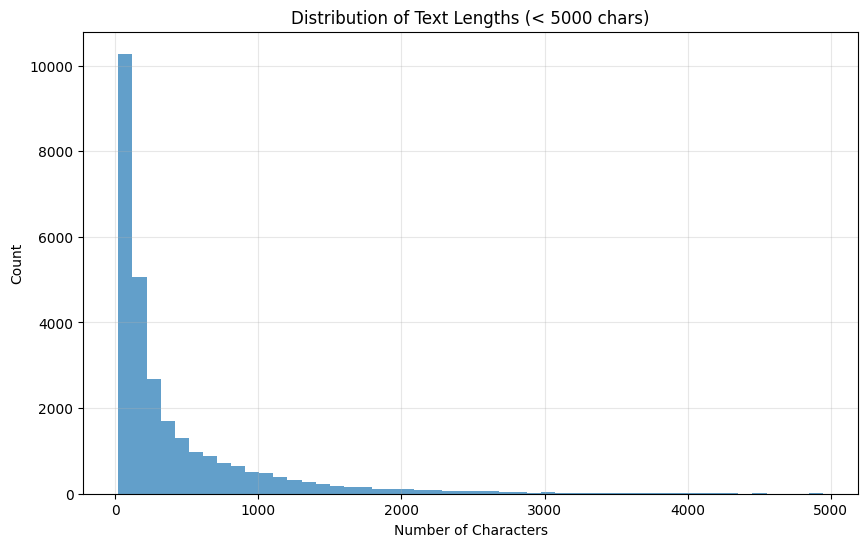

In [9]:
# %%
# Histogram of text lengths
plt.figure(figsize=(10, 6))
plt.hist(icd11_df['all_text_length'][icd11_df['all_text_length'] < 5000], bins=50, alpha=0.7)
plt.title('Distribution of Text Lengths (< 5000 chars)')
plt.xlabel('Number of Characters')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

In [10]:
# %%
# Identify entries with minimal text (potential issues for vectorization)
min_text_entries = icd11_df[icd11_df['all_text_length'] < 50]
print(f"\nNumber of entries with limited text (<50 chars): {len(min_text_entries)}")
print("Sample of entries with minimal text:")
print(min_text_entries[['code', 'title', 'all_text_length']].head())


Number of entries with limited text (<50 chars): 1441
Sample of entries with minimal text:
        code               title  all_text_length
809   2A01.0         Meningiomas               35
1290  2A00.0    Gliomas of brain               45
1451  2E80.0              Lipoma               25
1733     NaN  Diseases of spleen               49
1865    4B02         Eosinopenia               35


# 3. Text Preprocessing

In [11]:
# %%
def preprocess_text(text, remove_stopwords=False, stemming=False):
    """
    Clean and preprocess text data for language model input.

    Args:
        text: Input text string
        remove_stopwords: Whether to remove stopwords
        stemming: Whether to apply stemming

    Returns:
        Processed text string
    """
    if pd.isna(text) or text == '':
        return ''

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub('<.*?>', '', text)

    # Remove special characters but keep spaces between words
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = text.split()

    # Remove stopwords if requested
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

    # Apply stemming if requested
    if stemming:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

def create_complete_description(row, remove_stopwords=False, stemming=False):
    """
    Create a complete description by combining all text fields.

    Args:
        row: A row from the DataFrame
        remove_stopwords: Whether to remove stopwords
        stemming: Whether to apply stemming

    Returns:
        Combined and preprocessed text
    """
    # Combine all text fields, giving priority to the most informative ones
    combined_text = ' '.join([
        str(row['title'] or ''),
        str(row['definition'] or ''),
        str(row['inclusions'] or ''),
        str(row['index_terms'] or ''),
        str(row['full_text'] or '')
    ])

    # Preprocess the combined text
    return preprocess_text(combined_text, remove_stopwords, stemming)

# %%
# Apply preprocessing to text
print("Preprocessing text data...")
icd11_df['processed_text'] = icd11_df.apply(lambda row: create_complete_description(row), axis=1)
icd11_df['processed_text_length'] = icd11_df['processed_text'].str.len()

# Display stats after preprocessing
print(f"Mean text length after preprocessing: {icd11_df['processed_text_length'].mean():.1f}")
print(f"Min text length: {icd11_df['processed_text_length'].min()}")
print(f"Entries with empty text: {(icd11_df['processed_text_length'] == 0).sum()}")


Preprocessing text data...
Mean text length after preprocessing: 453.8
Min text length: 23
Entries with empty text: 0


In [12]:
# %%
# Enrich descriptions for codes with minimal information by using parent data
def enrich_description_with_hierarchy(df):
    """
    Enrich text descriptions of codes with minimal information
    by adding parent and child information.
    """
    # Create dictionary for faster lookups
    id_to_text = dict(zip(df['id'], df['processed_text']))

    # Find parent descriptions
    df['parent_text'] = df['parent'].map(id_to_text)

    # For entries with minimal text, enrich with parent information
    min_text_mask = df['processed_text_length'] < 30

    for idx in tqdm(df[min_text_mask].index, desc="Enriching descriptions"):
        parent_id = df.loc[idx, 'parent']
        if pd.notna(parent_id) and parent_id in id_to_text:
            parent_text = id_to_text[parent_id]
            if len(parent_text) > 0:
                # Add parent information to entities with minimal text
                df.loc[idx, 'processed_text'] += f" {parent_text}"

    # Update lengths
    df['processed_text_length'] = df['processed_text'].str.len()

    return df

icd11_df = enrich_description_with_hierarchy(icd11_df)

print(f"After enrichment - mean text length: {icd11_df['processed_text_length'].mean():.1f}")
print(f"After enrichment - entries with minimal text (<30 chars): {(icd11_df['processed_text_length'] < 30).sum()}")

Enriching descriptions:   0%|          | 0/56 [00:00<?, ?it/s]

After enrichment - mean text length: 453.8
After enrichment - entries with minimal text (<30 chars): 56


In [13]:
# Create a corpus for the language model, filtering out entries with insufficient text
min_length = 10  # Minimum number of characters to include in corpus
corpus = icd11_df[icd11_df['processed_text_length'] >= min_length]['processed_text'].tolist()
print(f"Corpus size for language model: {len(corpus)} documents")

# Print a sample to inspect
sample_size = min(5, len(corpus))
print("\nSample of processed text entries:")
for i in range(sample_size):
    print(f"Entry {i+1}: {corpus[i][:200]}...")

# For testing on M1 Mac with limited memory, we can use a smaller subset
# Uncomment the following line to use a smaller corpus for testing
# corpus = corpus[:1000]  # Use just 1000 documents for testing
# print(f"Using reduced corpus of {len(corpus)} documents for testing")

Corpus size for language model: 28087 documents

Sample of processed text entries:
Entry 1: infections due to chlamydia psittaci any condition caused by an infection with the gram negative bacteria chlamydia psittaci these conditions are characterised by variable clinical presentations such ...
Entry 2: gambiense trypanosomiasis a disease caused by an infection with the protozoan parasite trypanosoma brucei gambiense this disease is characterised by fever headache muscle and joint aches or malaise th...
Entry 3: typhoid fever a condition caused by an infection with the gram negative bacteria salmonella typhi this condition is characterised by an acute sustained fever this condition may present with weakness s...
Entry 4: cutaneous amoebiasis nan nan cutaneous amoebiasis amoebiasis of skin amoebic ulcer of skin cutaneous amoebiasis cutaneous amoebiasis amoebiasis of skin amoebic ulcer of skin...
Entry 5: infectious abscess of the central nervous system a focal suppurative process of the

# 4. GatorTron Model Loading

In [14]:
# %%
def load_gatortron_model():
    """
    Load the GatorTron base model from Hugging Face.
    """
    print("Loading GatorTron-base model...")
    model_name = "UFNLP/gatortron-base"

    # Load tokenizer and model with memory optimization for M1 Mac
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # For M1 Mac, load the model with memory efficiency settings
    if device.type == 'mps' or device.type == 'cpu':
        # Load with reduced precision to save memory
        model = AutoModelForMaskedLM.from_pretrained(
            model_name,
            low_cpu_mem_usage=True,
            torch_dtype=torch.float16 if device.type == 'mps' else torch.float32
        )
    else:
        # For GPU, we can load normally
        model = AutoModelForMaskedLM.from_pretrained(model_name)

    # Print model size
    num_params = sum(p.numel() for p in model.parameters()) / 1e6
    print(f"GatorTron model loaded with {num_params:.1f}M parameters")
    print(f"Vector dimension: {model.config.hidden_size}")

    return tokenizer, model

# %%
# Load the GatorTron model
tokenizer, model = load_gatortron_model()

# Move model to the appropriate device
model = model.to(device)

Loading GatorTron-base model...


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/379k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/713M [00:00<?, ?B/s]

MegatronBertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


model.safetensors:   0%|          | 0.00/713M [00:00<?, ?B/s]

GatorTron model loaded with 355.3M parameters
Vector dimension: 1024


# 5. Custom Dataset for Masked Language Modeling

In [15]:
# %%
# Define a custom dataset for masked language modeling
class MaskedLanguageModelingDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Handle empty text
        if not text or len(text) == 0:
            text = "empty"

        # Tokenize with optimized settings
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_special_tokens_mask=True,
            return_tensors='pt'
        )

        # Convert to 1D tensors
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        return item

# 6. Fine-tuning GatorTron on ICD-11 Descriptions

In [16]:
# %%
def fine_tune_gatortron(model, tokenizer, corpus, output_dir, epochs=1):
    """
    Fine-tune the GatorTron model on our ICD corpus using Masked Language Modeling.
    Optimized for M1 Mac with memory constraints.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create dataset with appropriate max_length
    dataset = MaskedLanguageModelingDataset(corpus, tokenizer, max_length=MAX_LENGTH)

    # Create data collator for masked language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,
        mlm_probability=0.15
    )

    # Define training arguments with memory optimizations
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=epochs,
        per_device_train_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=ACCUMULATION_STEPS,  # Accumulate gradients to simulate larger batch
        save_steps=2000,
        save_total_limit=1,  # Keep only 1 checkpoint to save space
        logging_dir=f"{output_dir}/logs",
        logging_steps=200,
        fp16=False,  # Disable fp16 which sometimes has issues on M1
        dataloader_num_workers=0,  # Set to 0 for single-process data loading
        dataloader_pin_memory=False,  # Disable pinned memory which might cause issues on M1
    )

    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=dataset,
    )

    # Train the model
    print("Fine-tuning GatorTron model...")
    print(f"This may take several hours. Started at: {time.strftime('%H:%M:%S')}")
    trainer.train()
    print(f"Fine-tuning completed at: {time.strftime('%H:%M:%S')}")

    # Save the model
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    return model, tokenizer

In [17]:
# %%
# Create output directory
output_dir = "icd11vec_gatortron"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set parameters based on available hardware
# For M1 Mac - use minimal values for testing
epochs = 1  # Use 1 epoch for testing, increase for better results

# Fine-tune the model on our corpus
# Note: This may take several hours on M1 Mac
# You can comment this out and load from a saved model if you've already fine-tuned
fine_tuned_model, tokenizer = fine_tune_gatortron(
    model, tokenizer, corpus, output_dir,
    epochs=epochs
)
#API key: ea1eae13b8276daf6c2178969fabe941c7687d01

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Fine-tuning GatorTron model...
This may take several hours. Started at: 15:17:45


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: giovannimantovani02 (giovannimantovani02-bocconi-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
200,0.473300
400,0.318900
600,0.297700
800,0.358200
1000,0.298900
1200,0.277400
1400,0.279300
1600,0.241700
1800,0.245200
2000,0.257300


Fine-tuning completed at: 16:48:28


# 7. Generating Vectors for ICD-11 Codes

In [18]:
# %%
def generate_gatortron_vectors(model, tokenizer, texts, batch_size=1):
    """
    Generate vectors using GatorTron with memory optimization for M1 Mac.

    Args:
        model: The fine-tuned GatorTron model
        tokenizer: The GatorTron tokenizer
        texts: List of preprocessed text documents
        batch_size: Size of batches to process at once

    Returns:
        Numpy array of vectors with shape (n_texts, vector_dim)
    """
    model.eval()  # Set model to evaluation mode
    vector_dim = model.config.hidden_size  # Should be 1024 for GatorTron

    # Create batches for memory efficiency
    batches = [texts[i:i+batch_size] for i in range(0, len(texts), batch_size)]
    vectors = []

    for batch in tqdm(batches, desc="Generating vectors"):
        # Handle empty or very short texts
        batch = [text if len(text) > 0 else "unknown" for text in batch]

        # Tokenize with memory-efficient settings
        inputs = tokenizer(
            batch,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        ).to(device)

        # Generate embeddings
        try:
            with torch.no_grad():
                # Access the base model (bert) inside MLM model
                if hasattr(model, 'bert'):
                    outputs = model.bert(**inputs)
                else:
                    outputs = model(**inputs)

            # Get the last hidden states
            last_hidden_states = outputs.last_hidden_state

            # Apply average pooling (as described in ICD2Vec paper)
            attention_mask = inputs['attention_mask'].unsqueeze(-1)
            sum_embeddings = torch.sum(last_hidden_states * attention_mask, dim=1)
            sum_mask = torch.sum(attention_mask, dim=1)
            pooled_embeddings = sum_embeddings / sum_mask

            # Convert to numpy and add to result list
            batch_vectors = pooled_embeddings.cpu().numpy()
            vectors.extend(batch_vectors)
        except Exception as e:
            print(f"Error processing batch: {e}")
            # Add zero vectors as fallback for failed batches
            zero_vectors = np.zeros((len(batch), vector_dim))
            vectors.extend(zero_vectors)

        # Clean up to free memory
        del inputs
        if 'outputs' in locals():
            del outputs
        if 'last_hidden_states' in locals():
            del last_hidden_states
        if 'pooled_embeddings' in locals():
            del pooled_embeddings

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Optional: Sleep briefly to allow memory cleanup
        time.sleep(0.05)

    return np.array(vectors)

In [19]:
# %%
# Generate vectors for all ICD-11 codes
print("Generating vectors for all ICD-11 codes...")
print(f"This may take 1-2 hours. Started at: {time.strftime('%H:%M:%S')}")
all_texts = icd11_df['processed_text'].tolist()

# For testing, you can use a subset
# all_texts = all_texts[:1000]  # Comment this out for full dataset
vectors = generate_gatortron_vectors(
    fine_tuned_model, tokenizer, all_texts,
    batch_size=1  # Process one at a time for M1 Mac
)
'''vectors = generate_gatortron_vectors(
    model, tokenizer, all_texts,
    batch_size=1  # Process one at a time for M1 Mac
)'''
print(f"Vector generation completed at: {time.strftime('%H:%M:%S')}")

# Add vectors to DataFrame
icd11_df['vector'] = list(vectors)

print(f"Generated vectors with shape: {vectors.shape}")
print(f"Vector dimension: {vectors.shape[1]}")  # Should be 1024 for GatorTron

Generating vectors for all ICD-11 codes...
This may take 1-2 hours. Started at: 16:49:34


Generating vectors:   0%|          | 0/28087 [00:00<?, ?it/s]

Vector generation completed at: 17:34:24
Generated vectors with shape: (28087, 1024)
Vector dimension: 1024


# 8. Vector Storage and Similarity Search

In [20]:
# %%
def normalize_vectors(vectors):
    """Normalize vectors for cosine similarity search."""
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    # Avoid division by zero
    norms[norms == 0] = 1e-10
    return vectors / norms

def create_faiss_index(vectors, index_type="L2"):
    """
    Create a FAISS index for vector similarity search.

    Args:
        vectors: numpy array of vectors
        index_type: Type of index (L2 for Euclidean distance, IP for inner product/cosine)

    Returns:
        FAISS index
    """
    vector_dim = vectors.shape[1]

    if index_type == "L2":
        # L2 distance (Euclidean)
        index = faiss.IndexFlatL2(vector_dim)
    else:
        # Inner product (for cosine similarity with normalized vectors)
        index = faiss.IndexFlatIP(vector_dim)

    # Add vectors to the index
    index.add(vectors.astype('float32'))

    return index

In [21]:
# %%
# Normalize vectors for cosine similarity
normalized_vectors = normalize_vectors(vectors)

# Create FAISS indices for both distance metrics
print("Creating FAISS indices...")
l2_index = create_faiss_index(vectors, "L2")
cosine_index = create_faiss_index(normalized_vectors, "IP")

# Save indices to disk
faiss.write_index(l2_index, f"{output_dir}/icd11_l2_index.faiss")
faiss.write_index(cosine_index, f"{output_dir}/icd11_cosine_index.faiss")
print("FAISS indices saved")


Creating FAISS indices...
FAISS indices saved


In [22]:
# %%
def search_similar_codes(query_text, model, tokenizer, index, df, top_k=5):
    """
    Search for ICD codes most similar to the query text.

    Args:
        query_text: Text to search for
        model: The fine-tuned model
        tokenizer: The tokenizer
        index: FAISS index for similarity search
        df: DataFrame with ICD-11 codes
        top_k: Number of results to return

    Returns:
        DataFrame with similar codes
    """
    # Preprocess query text
    processed_query = preprocess_text(query_text)

    # Generate vector for query
    query_vector = generate_gatortron_vectors(model, tokenizer, [processed_query], batch_size=1)[0]

    # If using cosine similarity, normalize the query vector
    if isinstance(index, faiss.IndexFlatIP):
        norm = np.linalg.norm(query_vector)
        if norm > 0:
            query_vector = query_vector / norm

    # Search the index
    distances, indices = index.search(query_vector.reshape(1, -1).astype('float32'), top_k)

    # Create a results DataFrame
    results = df.iloc[indices[0]].copy()
    results['distance'] = distances[0]

    # For IP index (cosine similarity), convert to similarity score
    if isinstance(index, faiss.IndexFlatIP):
        results['similarity'] = results['distance']  # Higher is better
    else:
        results['similarity'] = 1 / (1 + results['distance'])  # Convert distance to similarity

    return results[['code', 'title', 'definition', 'similarity']]


In [23]:
# %%
# Example queries to demonstrate vector search
example_queries = [
    "Diabetes with kidney complications",
    "Acute myocardial infarction",
    "Pneumonia caused by COVID-19",
    "Depression with anxiety symptoms",
    "Fracture of femur"
]

print("\nExample queries:")
for query in example_queries:
    print(f"\nQuery: '{query}'")

    # Search using cosine similarity
    results = search_similar_codes(
        query, fine_tuned_model, tokenizer, cosine_index, icd11_df, top_k=3
    )

    # Display results
    print("Top 3 similar ICD-11 codes:")
    for i, row in results.iterrows():
        print(f"Code: {row['code']} - {row['title']}")
        if pd.notna(row['definition']) and len(row['definition']) > 0:
            print(f"  Definition: {row['definition'][:100]}...")
        print(f"  Similarity: {row['similarity']:.4f}")


Example queries:

Query: 'Diabetes with kidney complications'


Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Top 3 similar ICD-11 codes:
Code: nan - Acute complications of diabetes mellitus
  Similarity: 0.8779
Code: 5A21 - Hypoglycaemia in the context of diabetes mellitus
  Similarity: 0.8477
Code: nan - Glomerular diseases
  Definition: Any disease characterised by pathological changes to the glomerulus....
  Similarity: 0.8432

Query: 'Acute myocardial infarction'


Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Top 3 similar ICD-11 codes:
Code: nan - Acute ischaemic heart disease
  Similarity: 0.8707
Code: BD30 - Acute arterial occlusion
  Similarity: 0.8076
Code: nan - Ischaemic heart diseases
  Similarity: 0.8075

Query: 'Pneumonia caused by COVID-19'


Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Top 3 similar ICD-11 codes:
Code: nan - Certain zoonotic viral diseases
  Similarity: 0.8414
Code: QC01.9 - Need for immunization against COVID-19
  Similarity: 0.8373
Code: 1D92 - Coronavirus infection, unspecified site
  Similarity: 0.8332

Query: 'Depression with anxiety symptoms'


Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Top 3 similar ICD-11 codes:
Code: nan - Problems associated with social or cultural environment
  Similarity: 0.8472
Code: nan - Symptoms or signs involving the circulatory system
  Similarity: 0.8363
Code: nan - Mental and emotional disorders (TM1)
  Similarity: 0.8359

Query: 'Fracture of femur'


Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Top 3 similar ICD-11 codes:
Code: NC72.2 - Fracture of neck of femur
  Similarity: 0.9056
Code: NC72.6 - Fracture of lower end of femur
  Similarity: 0.9000
Code: NC92.1 - Fracture of upper end of tibia
  Similarity: 0.8844


# 9. Vector Analysis and Visualization

In [24]:
# %%
def visualize_vectors_tsne(vectors, labels, title="t-SNE Visualization of ICD-11 Vectors",
                         perplexity=30, n_iter=1000, sample_size=1000):
    """
    Create a t-SNE visualization of the vector space.

    Args:
        vectors: Vectors to visualize
        labels: Labels for each vector (e.g., ICD codes or titles)
        title: Plot title
        perplexity: t-SNE perplexity parameter
        n_iter: Number of iterations for t-SNE
        sample_size: Number of points to sample (for large datasets)
    """
    # Sample if needed
    if len(vectors) > sample_size:
        indices = np.random.choice(len(vectors), sample_size, replace=False)
        sampled_vectors = vectors[indices]
        sampled_labels = [labels[i] for i in indices]
    else:
        sampled_vectors = vectors
        sampled_labels = labels

    # Apply t-SNE
    print(f"Applying t-SNE on {len(sampled_vectors)} vectors...")
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    vectors_2d = tsne.fit_transform(sampled_vectors)

    # Create plot
    plt.figure(figsize=(12, 10))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.6, s=10)

    # Add labels for some points (not all to avoid clutter)
    n_labels = min(20, len(sampled_labels))
    label_indices = np.random.choice(len(sampled_labels), n_labels, replace=False)

    for i in label_indices:
        plt.annotate(
            sampled_labels[i],
            (vectors_2d[i, 0], vectors_2d[i, 1]),
            fontsize=9,
            alpha=0.8
        )

    plt.title(title)
    plt.tight_layout()
    plt.show()

Applying t-SNE on 1000 vectors...


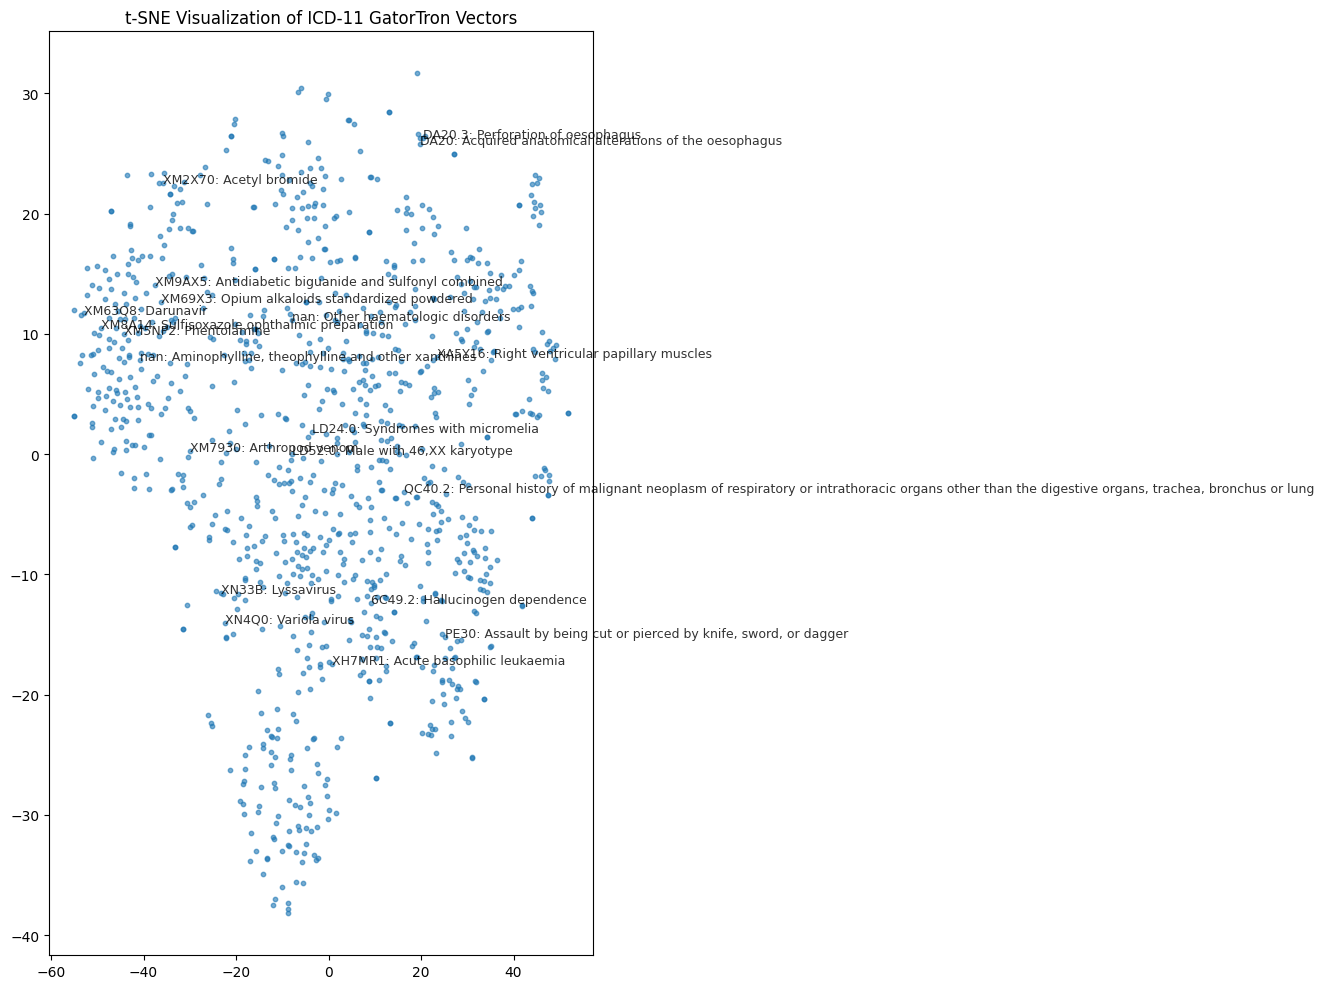

In [25]:
# %%
# Create t-SNE visualization of the vector space
# Use code titles as labels for better readability
labels = [f"{code}: {title}" for code, title in zip(icd11_df['code'], icd11_df['title'])]
visualize_vectors_tsne(
    vectors=vectors,
    labels=labels,
    title="t-SNE Visualization of ICD-11 GatorTron Vectors",
    perplexity=30,
    sample_size=1000  # Using a sample for faster visualization
)

# 10. Vector Arithmetic Demonstration (Like in ICD2Vec Paper)

In [26]:
# %%
def analyze_vector_arithmetic(model, tokenizer, index, df, examples=3):
    """
    Demonstrate vector arithmetic with medical concepts, similar to
    the approach used in the ICD2Vec paper.

    For example: diabetes + kidney ~= diabetic nephropathy
    """
    print("\nVector Arithmetic Examples:")

    # Example 1: diabetes + kidney ~= diabetic nephropathy
    if examples >= 1:
        print("\nExample 1: diabetes + kidney ≈ ?")
        # Get vectors for concepts
        diabetes_vector = generate_gatortron_vectors(model, tokenizer, ["diabetes"])[0]
        kidney_vector = generate_gatortron_vectors(model, tokenizer, ["kidney disease"])[0]

        # Perform vector arithmetic
        result_vector = diabetes_vector + kidney_vector
        result_vector = result_vector / np.linalg.norm(result_vector)  # Normalize

        # Search for closest concepts
        distances, indices = index.search(result_vector.reshape(1, -1).astype('float32'), 3)

        # Print results
        print("Result:")
        for i, idx in enumerate(indices[0]):
            code = df.iloc[idx].get('code', 'N/A')
            title = df.iloc[idx].get('title', 'N/A')
            similarity = distances[0][i]
            print(f"{i+1}. {code}: {title} (Similarity: {similarity:.4f})")

    # Example 2: pneumonia + virus ~= viral pneumonia
    if examples >= 2:
        print("\nExample 2: pneumonia + virus ≈ ?")
        pneumonia_vector = generate_gatortron_vectors(model, tokenizer, ["pneumonia"])[0]
        virus_vector = generate_gatortron_vectors(model, tokenizer, ["viral infection"])[0]

        result_vector = pneumonia_vector + virus_vector
        result_vector = result_vector / np.linalg.norm(result_vector)

        distances, indices = index.search(result_vector.reshape(1, -1).astype('float32'), 3)

        print("Result:")
        for i, idx in enumerate(indices[0]):
            code = df.iloc[idx].get('code', 'N/A')
            title = df.iloc[idx].get('title', 'N/A')
            similarity = distances[0][i]
            print(f"{i+1}. {code}: {title} (Similarity: {similarity:.4f})")

    # Example 3: heart attack - heart ~= stroke
    if examples >= 3:
        print("\nExample 3: heart attack - heart ≈ ?")
        heart_attack_vector = generate_gatortron_vectors(model, tokenizer, ["heart attack myocardial infarction"])[0]
        heart_vector = generate_gatortron_vectors(model, tokenizer, ["heart"])[0]

        result_vector = heart_attack_vector - heart_vector * 0.5  # Reduced weight to avoid going too far
        result_vector = result_vector / np.linalg.norm(result_vector)

        distances, indices = index.search(result_vector.reshape(1, -1).astype('float32'), 3)

        print("Result:")
        for i, idx in enumerate(indices[0]):
            code = df.iloc[idx].get('code', 'N/A')
            title = df.iloc[idx].get('title', 'N/A')
            similarity = distances[0][i]
            print(f"{i+1}. {code}: {title} (Similarity: {similarity:.4f})")

In [27]:
# %%
# Demonstrate vector arithmetic (like in the ICD2Vec paper)
analyze_vector_arithmetic(fine_tuned_model, tokenizer, cosine_index, icd11_df)


Vector Arithmetic Examples:

Example 1: diabetes + kidney ≈ ?


Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Result:
1. nan: Diseases of spleen (Similarity: 0.8500)
2. MG24.0: Fear of cancer (Similarity: 0.8402)
3. NB92.0: Injury of kidney (Similarity: 0.8400)

Example 2: pneumonia + virus ≈ ?


Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Result:
1. nan: Viral infection of unspecified site (Similarity: 0.8389)
2. nan: Virus (Similarity: 0.8381)
3. MG24.0: Fear of cancer (Similarity: 0.8377)

Example 3: heart attack - heart ≈ ?


Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Generating vectors:   0%|          | 0/1 [00:00<?, ?it/s]

Result:
1. nan: Acute ischaemic heart disease (Similarity: 0.7772)
2. BA42: Subsequent myocardial infarction (Similarity: 0.7413)
3. BA60: Certain current complications following acute myocardial infarction (Similarity: 0.7317)


# 11. Export for Integration with Open Doctor

In [28]:
# %%
def export_vectors_json(df, vector_column='vector', output_file='icd11_vectors.json'):
    """
    Export vectors and metadata to JSON for integration with other systems.

    Args:
        df: DataFrame with ICD-11 codes and vectors
        vector_column: Name of the column containing vectors
        output_file: Path to the output file
    """
    # Create a list of dictionaries with code metadata and vectors
    export_data = []

    for _, row in df.iterrows():
        if pd.isna(row.get('code')):
            continue

        item = {
            'id': str(row.get('id', '')),
            'code': str(row.get('code', '')),
            'title': str(row.get('title', '')),
            'vector': row[vector_column].tolist() if hasattr(row[vector_column], 'tolist') else row[vector_column]
        }
        export_data.append(item)

    # Export to JSON
    with open(output_file, 'w') as f:
        json.dump(export_data, f)

    print(f"Vectors exported to {output_file}")

    return export_data

In [29]:
# %%
# Export vectors to JSON
export_vectors_json(icd11_df, vector_column='vector', output_file=f"{output_dir}/icd11_vectors.json")

# Save vectors to numpy file for more efficient loading
np.save(f"{output_dir}/icd11_vectors.npy", vectors)
print(f"Vectors saved to {output_dir}/icd11_vectors.npy")

# Save metadata separately
metadata = icd11_df[['id', 'code', 'title', 'definition']].copy()
metadata.to_csv(f"{output_dir}/icd11_metadata.csv", index=False)
print(f"Metadata saved to {output_dir}/icd11_metadata.csv")

Vectors exported to icd11vec_gatortron/icd11_vectors.json
Vectors saved to icd11vec_gatortron/icd11_vectors.npy
Metadata saved to icd11vec_gatortron/icd11_metadata.csv
